## Model Training

#### 1.1 Import Data and Required Packages

In [40]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [41]:
df = pd.read_csv('data/StudentsPerformance.csv')

#### Show Top 5 Records

In [42]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Preparing X and Y variables

In [43]:
X = df.drop(columns=['math score'],axis=1)

In [44]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [45]:
y = df['math score']

In [46]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

In [47]:
print("Categories in 'gender' variable:", df['gender'].unique())
print("Categories in 'race/ethnicity' variable:", df['race/ethnicity'].unique())
print("Categories in 'parental level of education' variable:", df['parental level of education'].unique())
print("Categories in 'lunch' variable:", df['lunch'].unique())
print("Categories in 'test preparation course' variable:", df['test preparation course'].unique())

Categories in 'gender' variable: ['female' 'male']
Categories in 'race/ethnicity' variable: ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in 'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable: ['standard' 'free/reduced']
Categories in 'test preparation course' variable: ['none' 'completed']


In [48]:
# Define numerical and categorical features
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

In [49]:
# Create Column Transformer with 3 types of transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [50]:
X = preprocessor.fit_transform(X)

In [51]:
X

array([[ 0.19399858,  0.39149181,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.42747598,  1.31326868,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 1.77010859,  1.64247471,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.12547206, -0.20107904,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.60515772,  0.58901542,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 1.15336989,  1.18158627,  1.        , ...,  0.        ,
         0.        ,  1.        ]])

In [52]:
X.shape

(1000, 19)

In [53]:
from sklearn.model_selection import train_test_split

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 19)
X_test shape: (200, 19)
y_train shape: (800,)
y_test shape: (200,)


#### Create an Evaluate Function to give all metrics after model Training

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(true, predicted, verbose=False):
    # Calculate Mean Absolute Error (average absolute difference between actual and predicted values)
    mae = mean_absolute_error(true, predicted)

    # Calculate Mean Squared Error (average of squared differences)
    mse = mean_squared_error(true, predicted)
    
    # Calculate Root Mean Squared Error (square root of MSE for same unit as original data)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    
    # Calculate R-squared (proportion of variance explained by the model)
    r2 = r2_score(true, predicted)
    
    # If verbose is True, print the evaluation metrics
    if verbose:
        print(f"MAE: {mae:.3f}")     # Print MAE rounded to 3 decimal places
        print(f"RMSE: {rmse:.3f}")
        print(f"R²: {r2:.3f}")
    
    return mae, rmse, r2

In [57]:
# Dictionary of regression models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),  # suppress CatBoost's verbose output
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Lists to store results
model_list = []  # Stores model names
r2_list = []     # Stores R² scores from the test set

# Loop through each model
for i in range(len(list(models))):
    model = list(models.values())[i]  # Get model instance
    model_name = list(models.keys())[i]  # Get model name
    
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate performance on the training set
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    
    # Evaluate performance on the test set
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Store model name and R² score for test set
    model_list.append(model_name)
    r2_list.append(model_test_r2)
    
    # Print results
    print(model_name)
    print("Model performance for Training set")
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    
    print('----------------------------------')
    
    print("Model performance for Test set")
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('=' * 35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7128
- Mean Absolute Error: 4.5168
- R2 Score: 0.8552
-----------------------

### Results

In [67]:
pd.DataFrame(
    list(zip(model_list, r2_list)),          # Combine model names and R² scores as tuples
    columns=['Model Name', 'R2_Score']       # Set column names
).sort_values(
    by=["R2_Score"],                         # Sort by R² score
    ascending=False                          # Best scores on top
)


,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880433
7,CatBoosting Regressor,0.851632
5,Random Forest Regressor,0.851277
8,AdaBoost Regressor,0.847830
1,Lasso,0.825320
6,XGBRegressor,0.821220
3,K-Neighbors Regressor,0.783770
4,Decision Tree,0.754868


### Continuing with: Linear Regression

In [ ]:
# Initialize and train the linear regression model
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train, y_train)

# Predict on test set
y_pred = lin_model.predict(X_test)

# Calculate R² score as a percentage
r2_percent = r2_score(y_test, y_pred) * 100

# Accuracy of the model
print("R² Score (Test Set): %.2f%%" % r2_percent)

R² Score (Test Set): 88.04%


### Plot y_pred and y_test

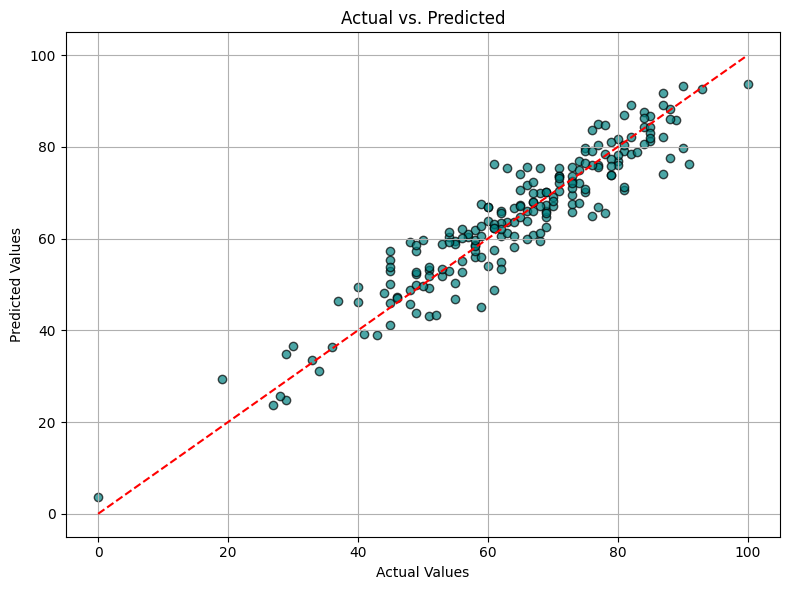

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal', edgecolors='k')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # y = x line
plt.grid(True)
plt.tight_layout()
plt.show()

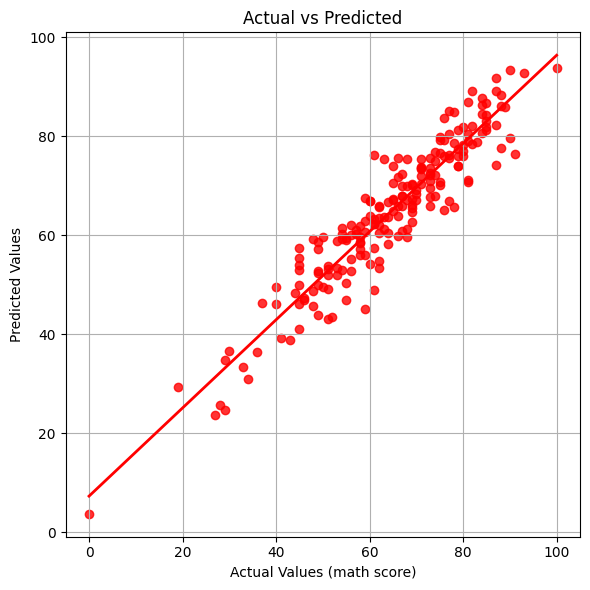

In [74]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_test, y=y_pred, ci=None, color='red', line_kws={"linewidth":2})
plt.xlabel('Actual Values (math score)')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Difference between Actual and Predicted Values

In [75]:
pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred,
    'Difference': y_test - y_pred
})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
